## 1D Fourier Neural Network for Burger's Equation

$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = v \frac {\partial^2 u}{\partial x^2}$

Input(Boundary condition): $u(x,t=0)$

Output: $u(x,t=1)$

data in data/burgers_data_R10.amt

In [21]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

torch.manual_seed(0)
np.random.seed(0)

In [22]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):

        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [28]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 40
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 16
width = 64

In [29]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = MatReader('data/burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

# cat the locations information
grid = np.linspace(0, 1, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

287425


In [30]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        # mse.backward()
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

# torch.save(model, 'model/ns_fourier_burgers')
pred = torch.zeros(y_test.shape)
benchmark = torch.zeros(y_test.shape)
inputs = torch.zeros(x_test.shape)

index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        pred[index] = out.squeeze()
        benchmark[index] = y
        inputs[index] = x.squeeze()

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

    scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})
    scipy.io.savemat('pred/burger_benchmark.mat', mdict={'benchmark': benchmark.cpu().numpy()})
    scipy.io.savemat('pred/burger_inputs.mat', mdict={'inputs': inputs.cpu().numpy()})


0 0.3025146999998469 0.09085343170911074 0.5333141107559204 0.261688289642334
1 0.2833844999995563 0.010716649871319532 0.19621572065353393 0.17234138011932373
2 0.2814293000001271 0.00418260526843369 0.11978134250640869 0.09191190242767334
3 0.2830744999992021 0.001232354094972834 0.05791034734249115 0.04857051730155945
4 0.2809960999993564 0.0008209244825411588 0.04954960143566132 0.08660522222518921
5 0.2817325999994864 0.0014820589101873338 0.08663803625106811 0.10740788936614991
6 0.2814548000005743 0.001334799868054688 0.07678399205207825 0.09212819814682006
7 0.2813848000005237 0.0015406818222254515 0.08489542198181152 0.05539649486541748
8 0.2822638999996343 0.0006754696753341705 0.054984976768493656 0.0734979248046875
9 0.2802921000002243 0.000504898721119389 0.04534402096271515 0.044331190586090086
10 0.28038500000002387 0.0004058589384658262 0.04263992714881897 0.06473022937774658
11 0.2807649999995192 0.0006266485853120685 0.056448202133178714 0.05734541177749634
12 0.28278

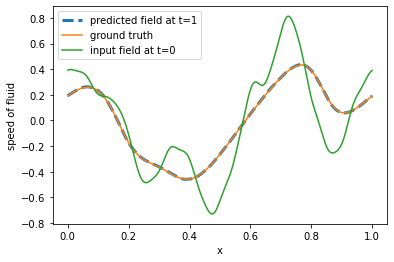

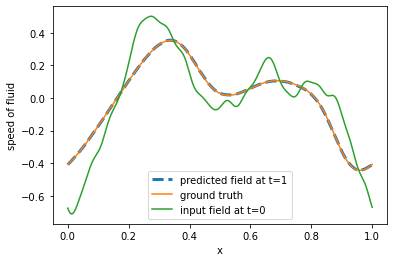

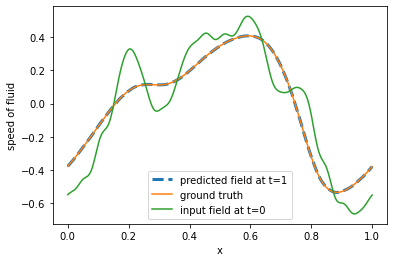

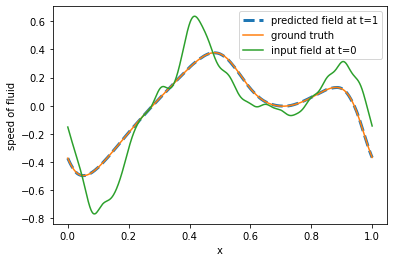

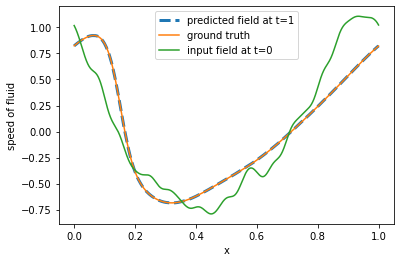

In [31]:
pred = scipy.io.loadmat('pred/burger_test.mat')
pred = pred['pred']

inputs = scipy.io.loadmat('pred/burger_inputs.mat')
inputs = inputs['inputs']

benchmark = scipy.io.loadmat('pred/burger_benchmark.mat')
benchmark = benchmark['benchmark']

xx = inputs[1,:,1]

for k in range(1,10,2):
    plt.figure()
    plt.plot(xx,pred[k,:],'--',label = 'predicted field at t=1',linewidth=3)
    plt.plot(xx,benchmark[k,:],label = 'ground truth')
    plt.plot(xx,inputs[k,:,0],label='input field at t=0')
    plt.xlabel('x')
    plt.ylabel('speed of fluid')
    plt.legend()
    plt.show()
